# Run parallel calls to OpenAI on a dataset, with rate limit

In this notebook, you'll learn how to run multiple parallel calls to OpenAI on a dataset with a rate limit. 

As an example, we'll take a bunch of Amazon reviews as a dataset. Our goal is to **extract keywords** from the reviews. The way we extract keywords is by making a call to OpenAI GPT-4 and asking to list the keywords. 

To do that, here is what we will do:

1. Load the dataset
2. Make API calls to OpenAI
3. Parallelize the calls while respecting the OpenAI rate limits
4. Displaying results

Let's go!

In [ ]:
!pip install "phospho[lab]"

In [1]:
import pandas as pd
import re
import os
import openai 

from phospho import lab
from dotenv import load_dotenv

load_dotenv()

assert os.environ.get("OPENAI_API_KEY"), "Please set the OPENAI_API_KEY environment variable."

## Load dataset

For demonstration purposes, we'll use a subset of the [Amazon Reviews dataset, collected in 2023 by McAuley Lab](https://amazon-reviews-2023.github.io).

In [2]:
messages_df = pd.read_csv('data/Magazine_Subscriptions_5.csv')
# Create a new column to store the message id
messages_df["id"] = messages_df.index.astype(str)

In [3]:
messages_df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,id
0,4,True,"02 26, 2014",A5QQOOZJOVPSF,B00005N7P0,John L. Mehlmauer,"I'm old, and so is my computer. Any advice th...",Cheapskates guide,1393372800,NaN,NaN,NaN,0


The first thing we need to do is to transform this dataset in a list of phospho `lab.Message`, which is a data format more adapted for what we need to do. 

In [4]:
# Convert every valid row of the df into a lab.Message
messages = lab.Message.from_df(messages_df, content="reviewText", created_at="unixReviewTime", id="id")
messages[:4]

[Message(id='0', created_at=1393372800, role=None, content="I'm old, and so is my computer.  Any advice that can help me maximize my computer perfomance is very welcome.  MaximumPC has some good tips on computer parts, vendors, and usefull tests", previous_messages=[], metadata={}),
 Message(id='1', created_at=1078531200, role=None, content="There's nothing to say, but if you want a REAL men's magazine, this is it. They have great articles and stories, and I love the bits of knowledge that starts the Know & Tell section, and I love the last page, which has an interview with a celebrity. Just get this magazine and forget all the other mature men's mags.", previous_messages=[], metadata={}),
 Message(id='2', created_at=1058227200, role=None, content="If you're the kind of man who looks at himself in a full length mirrror every morning, this is the magazine for you.\nIf you think the car you drive defines you, the clothes you wear are the measure of your self-worth, the watch on your wris

## Make API calls to OpenAI

Let's create a function that takes a message content as an input, and then make a call to OpenAI to get a list of keywords. 

### Step by step

First, we'll take a message. 

In [5]:
message = messages[0]
message

Message(id='0', created_at=1393372800, role=None, content="I'm old, and so is my computer.  Any advice that can help me maximize my computer perfomance is very welcome.  MaximumPC has some good tips on computer parts, vendors, and usefull tests", previous_messages=[], metadata={})

Then, we embed it into a prompt that we make to OpenAI.

In [6]:
openai_client = openai.AsyncClient(api_key=os.environ["OPENAI_API_KEY"])

# Label every message with keywords it contains
prompt = f"""You are an annotator reading Amazon product reviews. Your job is to label
each review with keywords that describe the main topics covered in the review.
The review is: 
{message.content}

Return a list of max 10 keywords as a bullet point list: `- keyword1\n- keyword2\n- keyword3`
Keywords:"""

response = await openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "You are a business analyst, expert in e-commerce.",
        },
        {"role": "user", "content": prompt},
    ],
)
response.choices[0].message.content

'- old computer\n- maximize performance\n- computer parts\n- vendors\n- useful tests\n- MaximumPC'

Finally, we use regex to read the response. 

In [7]:
response = response.choices[0].message.content
# Parse the response to extract the keywords with regex
keywords = re.findall(r"- (.*)", response)
keywords

['old computer',
 'maximize performance',
 'computer parts',
 'vendors',
 'useful tests',
 'MaximumPC']

### Turn this into a phospho job

Okay, let's muscle up and turn this proof of concept into a function.

However, let's respect the phospho job convention. To respect the convention, we need the function to take a lab.Message as an input, and return a lab.JobResult as an output.

Respecting this format helps us parallelize the calls later on. 

Here's what the function looks like:

In [8]:
async def get_keywords(
    message: lab.Message,
    model: str="openai:gpt-3.5-turbo",
) -> lab.JobResult:
    """
    This function uses OpenAI GPT to extract keywords from a given message.
    """
    provider, model_name = lab.get_provider_and_model(model)
    openai_client = lab.get_async_client(provider)

    # Label every message with keywords it contains
    prompt = f"""You are an annotator reading Amazon product reviews. Your job is to label
    each review with topics that describe important topics covered in the review, relevant
    to the e-commerce domain. Do not include generic topics such as "good", "bad", "interesting", etc.
    
    The review is: 
    {message.content}

    Return a list of max 10 keywords as a bullet point list: `- keyword1\n- keyword2\n- keyword3`
    Keywords:"""

    response = await openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a business analyst, expert in e-commerce.",
            },
            {"role": "user", "content": prompt},
        ],
    )

    response = response.choices[0].message.content
    # Parse the response to extract the keywords with regex
    keywords = re.findall(r"- (.*)", response)
    # Let's trim and lowercase the keywords
    keywords = [keyword.strip().lower() for keyword in keywords]
    return lab.JobResult(
        value=keywords,
        result_type=lab.ResultType.list,
    )

Easy, right ? Let's try the function on a single keyword:

In [9]:
# Try the function one a single message
await get_keywords(messages[0])

JobResult(value=['computer performance tips', 'maximumpc', 'computer parts', 'vendors', 'useful tests'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710804893, job_id=None)

## Run the job on multiple messages

Now, let's run the jobs on the dataset. 

### Without phospho

With a simple for loop, you have to wait for a full API call to complete before running the next one. This takes a long time.  

With **parallelism**, you can make multiple calls at the same time, but debugging becomes much harder.

Moreover, OpenAI and model providers have set up **rate limits.** If you parallelize without care, you will reach rate limits of OpenAI, and your requests will fail.

### With phospho

phospho introduces the abstraction of a Workload. A workload is a set of jobs to run. 

In [10]:
workload = lab.Workload(jobs=[lab.Job(job_function=get_keywords)])

No job_config provided. Running with empty config


A workload offers quick configuration for the problem presented before:
- `executor_mode`: switch between `sequential` to debug and `parallel` to parallelize API cals
- `max_parallelism`: slow down purposefuly the number of requests per second to avoid being rate limited.

Here is how to run a workload.

In [11]:
# Run the workload on the messages
await workload.async_run(
    messages[:100], # Replace by messages to run on the whole dataset
    executor_type="parallel", # Run the job on every messages in parallel
    max_parallelism=10, # Start at most 10 jobs per second to avoid rate limiting
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


{'0': {'get_keywords': JobResult(value=['computer performance', 'tips', 'computer parts', 'vendors', 'useful tests', 'advice', 'maximize', 'maximumpc'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710804712, job_id='get_keywords')},
 '1': {'get_keywords': JobResult(value=["men's magazine", 'articles', 'stories', 'know & tell section', 'celebrity interviews', "mature men's magazines", 'content quality', 'magazine recommendation'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710804711, job_id='get_keywords')},
 '2': {'get_keywords': JobResult(value=['self-image', 'materialism', 'status symbol', 'societal expectations', 'appearance-oriented', 'magazine content', 'consumer culture', 'lifestyle validation'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710804712, job_id='get_keywords')},
 '3': {'get_keywords': JobResult(value=['advertisement', 'little content'], result_type=<ResultType.list: 'list'>, logs=

Results are stored in the workload, in a dictionary: `message_id -> job_id -> JobResult`

In [12]:
workload.results["0"]

{'get_keywords': JobResult(value=['computer performance', 'tips', 'computer parts', 'vendors', 'useful tests', 'advice', 'maximize', 'maximumpc'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710804712, job_id='get_keywords')}

## Display results

Now that we ran the keyword detection on our dataset, let's get the results in a format more adapted for analytics.

In [13]:
# In this df, the index is the message_id, and the column is the job_id
results_df = workload.results_df()
results_df.head(3)

,get_keywords
0,"[computer performance, tips, computer parts, v..."
1,"[men's magazine, articles, stories, know & tel..."
10,"[glamour magazine, articles content, fashion, ..."


And join back the outputs with the original dataframe. 

In [14]:
augmented_messages_df = results_df.merge(messages_df, left_index=True, right_on="id")
augmented_messages_df.head(3)

,get_keywords,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,id
0,"[computer performance, tips, computer parts, v...",4,True,"02 26, 2014",A5QQOOZJOVPSF,B00005N7P0,John L. Mehlmauer,"I'm old, and so is my computer. Any advice th...",Cheapskates guide,1393372800,NaN,NaN,NaN,0
1,"[men's magazine, articles, stories, know & tel...",5,False,"03 6, 2004",A5RHZE7B8SV5Q,B00005N7PS,gorillazfan249,"There's nothing to say, but if you want a REAL...",The best mature Men's magazine.,1078531200,3.0,NaN,NaN,1
10,"[glamour magazine, articles content, fashion, ...",5,True,"06 12, 2017",A2VRQ8RNTKY1XT,B00005N7QC,Barbara M. Fox,I love glamour mag. I have read it for over 25...,Great magazine,1497225600,NaN,{'Format:': ' Kindle Edition'},NaN,10


In [15]:
print("Number of different keywords extracted:", augmented_messages_df["get_keywords"].explode().nunique())

Number of different keywords extracted: 433


We can now have tons of fun with the extracted keywords and do all kind of data analytics. 

<Axes: title={'center': 'Most common keywords in the dataset'}, xlabel='get_keywords'>

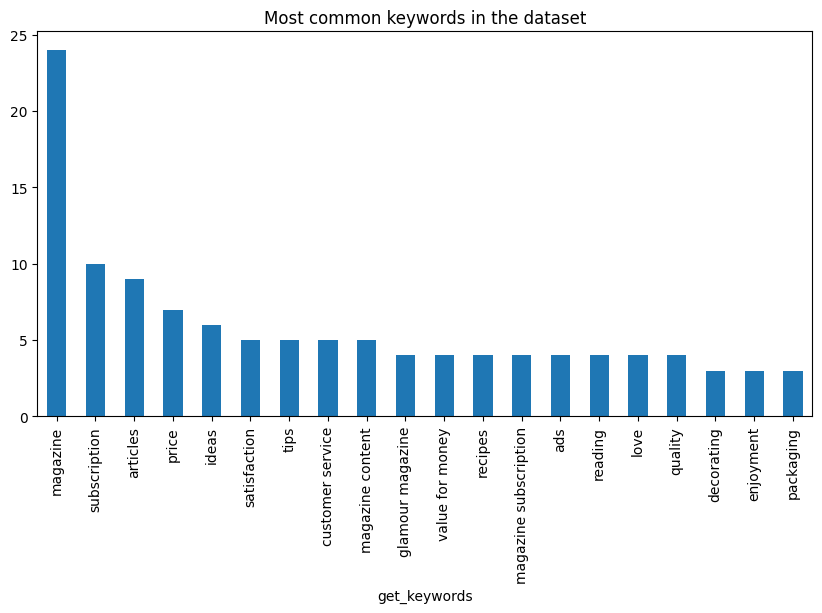

In [16]:
# Eg: Count the number of messages that contain a specific keyword

keywords_to_count = augmented_messages_df.explode("get_keywords").groupby("get_keywords").size().sort_values(ascending=False)

keywords_to_count.head(20).plot(kind="bar", figsize=(10, 5), title="Most common keywords in the dataset")

## Bonus: Use the previous results of the job

This PoC was cool, but all the Job execution are independent. 

Let's say that you want to **use the previous results of the job** as context for the current message. For example, to anchor the LLM with the current keywords found.

There are multiple ways to do it. 

### With phospho

With phospho, one cool way is to set a `job` argument to the job function. At runtime, `job` is then a reference to the current lab.Job and contains all results so far.

In [17]:
async def get_keywords_previous_results(
    message: lab.Message,
    job: lab.Job = None, # Add the job as an argument
    model: str="openai:gpt-3.5-turbo",
) -> lab.JobResult:
    """
    This function uses OpenAI GPT to extract keywords from a given message.

    It also uses the previous results of the job to provide context to the LLM.
    The job argument is used to access the previous results.
    """
    provider, model_name = lab.get_provider_and_model(model)
    openai_client = lab.get_async_client(provider)

    # Using the reference to the job, we can access the results of the other jobs
    # to use them as context for the current job
    previous_keywords = []
    if job:
        # Get the previous results
        previous_job_results = job.results.values()
        # Let's flatten the list of lists of keywords
        previous_keywords = [keyword for result in previous_job_results for keyword in result.value]

    prompt = "You are an annotator reading Amazon product reviews. Your job is to label \
    each review with topics that describe important topics covered in the review, relevant \
    to the e-commerce domain. Do not include generic topics such as 'good', 'bad', 'interesting', etc."
    
    # If there are previous results, we add them to the prompt
    if len(previous_keywords) > 0:
        prompt += f"""
        So far, you've reviewed {len(previous_job_results)} reviews, and the keywords you've found are:
        {", ".join(previous_keywords)}

        If possible, reuse the existing topics to label the current review. Do not add 
        variations of the same topics."""

    prompt = f"""The review is: 
    {message.content}

    Return a list of max 10 keywords as a bullet point list: `- keyword1\n- keyword2\n- keyword3`
    Keywords:"""

    response = await openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a business analyst, expert in e-commerce.",
            },
            {"role": "user", "content": prompt},
        ],
    )

    response = response.choices[0].message.content
    keywords = re.findall(r"- (.*)", response)
    keywords = [keyword.strip().lower() for keyword in keywords]
    return lab.JobResult(
        value=keywords,
        result_type=lab.ResultType.list,
    )

Let's run this job. 

Note that we are still running the jobs in parallel! This means that the existing results won't always be available at the start. 

No job_config provided. Running with empty config
100%|██████████| 100/100 [00:38<00:00,  2.60it/s]

Number of different keywords extracted: 588


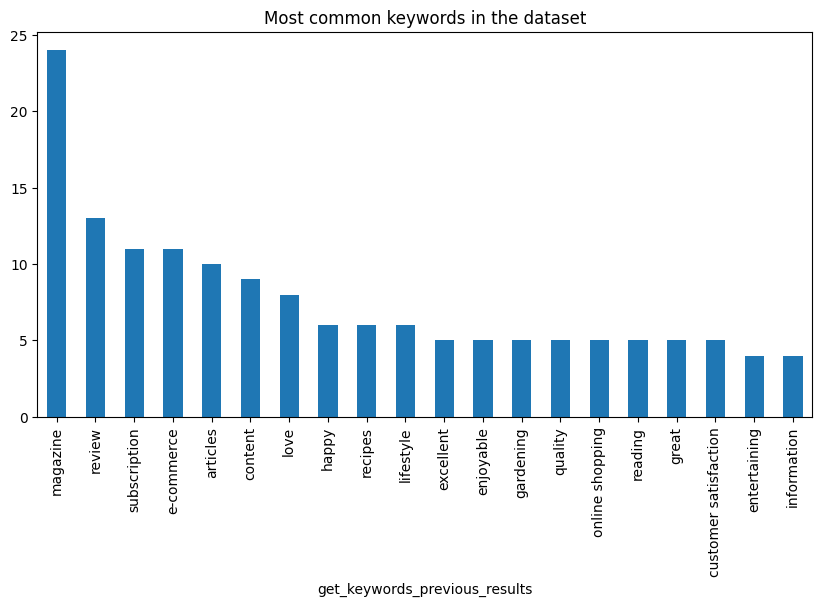

In [18]:
# Create workload
workload = lab.Workload(jobs=[lab.Job(job_function=get_keywords_previous_results)])

# Run
await workload.async_run(
    messages[:100], 
    executor_type="parallel",
    max_parallelism=10, 
)

# Display results
results_df = workload.results_df()
augmented_messages_df = results_df.merge(messages_df, left_index=True, right_on="id")

keywords_to_count = (
    augmented_messages_df.explode("get_keywords_previous_results")
    .groupby("get_keywords_previous_results")
    .size()
    .sort_values(ascending=False)
)
keywords_to_count.head(20).plot(
    kind="bar", figsize=(10, 5), title="Most common keywords in the dataset"
)

print("Number of different keywords extracted:", augmented_messages_df["get_keywords_previous_results"].explode().nunique())

### Reuse the results from another job

Likewise, you can set a `workload` argument. This lets you also use results on other jobs to augment the result of the current one.

Let's use this to **run the topic extraction on GPT-4 first on a subsample,** and then use GPT-3.5.

In [21]:
async def get_keywords_previous_jobs(
    message: lab.Message,
    workload: lab.Workload = None, # Add the job as an argument
    model: str="openai:gpt-3.5-turbo",
) -> lab.JobResult:
    """
    This function uses OpenAI GPT to extract keywords from a given message.

    It uses the results of the previous jobs to provide context to the current job.
    The workload argument is used to access the results of the previous jobs.
    The previous jobs are expected to be named `get_keywords`.

    If the message.id was already processed, the previous result is returned.
    """
    provider, model_name = lab.get_provider_and_model(model)
    openai_client = lab.get_async_client(provider)

    # Using the reference to the job, we can access the results of the other jobs
    # to use them as context for the current job
    previous_keywords = []
    if workload:
        # Get the previous results of the job `get_keywords` 
        previous_job_results = workload.jobs["get_keywords"].results.values()
        # Filter out None results
        previous_job_results = [result for result in previous_job_results if result]

        # If this message.id was already processed, we return the previous result
        if message.id in previous_job_results:
            return previous_job_results[message.id]

        # Otherwise, let's flatten the list of lists of keywords
        previous_keywords = [keyword for result in previous_job_results for keyword in result.value]

    prompt = "You are an annotator reading Amazon product reviews. Your job is to label \
    each review with topics that describe important topics covered in the review, relevant \
    to the e-commerce domain. Do not include generic topics such as 'good', 'bad', 'interesting', etc."
    
    # If there are previous results, we add them to the prompt
    if len(previous_keywords) > 0:
        prompt += f"""
        So far, you've reviewed {len(previous_job_results)} reviews, and the keywords you've found are:
        {", ".join(previous_keywords)}

        If possible, reuse the existing topics to label the current review. Do not add 
        variations of the same topics."""

    prompt = f"""The review is: 
    {message.content}

    Return a list of max 10 keywords as a bullet point list: `- keyword1\n- keyword2\n- keyword3`
    Keywords:"""

    response = await openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a business analyst, expert in e-commerce.",
            },
            {"role": "user", "content": prompt},
        ],
    )

    response = response.choices[0].message.content
    # Parse the response to extract the keywords with regex
    keywords = re.findall(r"- (.*)", response)
    keywords = [keyword.strip().lower() for keyword in keywords]
    return lab.JobResult(
        value=keywords,
        result_type=lab.ResultType.list,
    )

Let's use this to run 10 expensive calls to GPT-4, and then use those keywords as grounding when calling GPT-3.5.

In [22]:
# First, we run on GPT-4
# We create a new job config to specify the model


class GPT4Config(lab.JobConfig):
    model: str = "openai:gpt-4"


workload = lab.Workload(
    jobs=[
        # The jobs are executed sequentially, in the order they are defined
        lab.Job(
            job_function=get_keywords,
            config=GPT4Config(), # We specify the model
            sample=0.1, # We only run on 10% of the data
        ),
        lab.Job(job_function=get_keywords_previous_jobs),
    ]
)
await workload.async_run(
    messages[:100],
    executor_type="parallel",
    max_parallelism=10,
)

No job_config provided. Running with empty config
100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


{'0': {'get_keywords': None,
  'get_keywords_previous_jobs': JobResult(value=['computer performance', 'optimization', 'upgrades', 'maintenance', 'software', 'hardware', 'speed', 'seniors', 'maximumpc', 'tips'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710812174, job_id='get_keywords_previous_jobs')},
 '1': {'get_keywords': None,
  'get_keywords_previous_jobs': JobResult(value=["men's magazine", 'great articles', 'stories', 'knowledge', 'know & tell', 'celebrity interview', 'mature', 'entertainment', 'recommended', 'exclusive'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710812174, job_id='get_keywords_previous_jobs')},
 '2': {'get_keywords': None,
  'get_keywords_previous_jobs': JobResult(value=['lifestyle', 'narcissism', 'materialism', 'self-worth', 'social status', 'appearance', 'values', 'relationships', 'society', 'magazine'], result_type=<ResultType.list: 'list'>, logs=[], metadata={}, created_at=1710812174, job_id='get

Number of different keywords extracted: 590


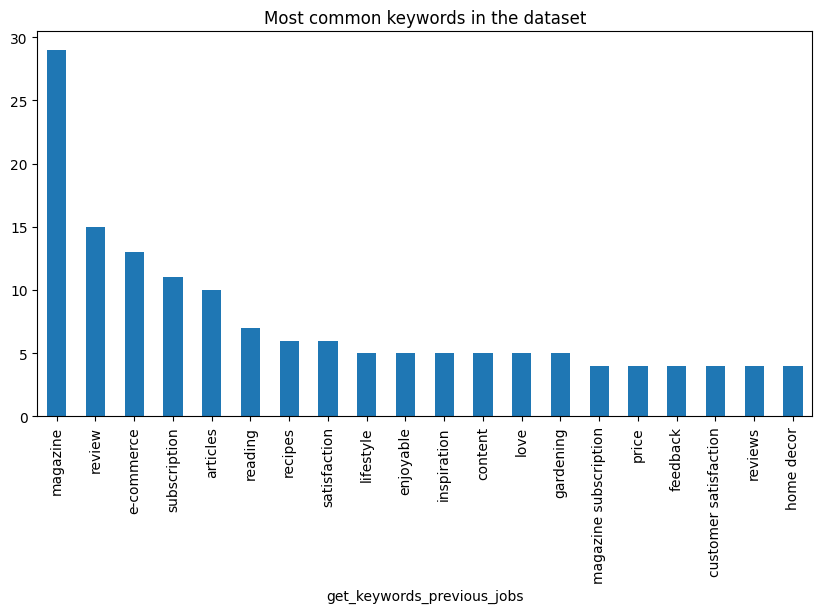

In [23]:
# Display results
results_df = workload.results_df()
augmented_messages_df = results_df.merge(messages_df, left_index=True, right_on="id")

keywords_to_count = (
    augmented_messages_df.explode("get_keywords_previous_jobs")
    .groupby("get_keywords_previous_jobs")
    .size()
    .sort_values(ascending=False)
)
keywords_to_count.head(20).plot(
    kind="bar", figsize=(10, 5), title="Most common keywords in the dataset"
)

print("Number of different keywords extracted:", augmented_messages_df["get_keywords_previous_jobs"].explode().nunique())

## Conclusion

In this notebook, we showed how to use phospho lab to

1. load a dataset 
2. parallelize calls to LLM providers (OpenAI)
3. respect API providers rate limits
4. use the results of the current job or of previous jobs
5. use config and sampling to switch from expensive to cheap model

Discover more about phospho in the [documentation!](https://docs.phospho.ai)